<img src="https://i.imgur.com/kdDweco.png" align=center>

# CMEMS_3 DIVE 
# Part 2: The Leeuwin current annual cycle

Start with having a look at the following article on [the Leeuwin current annual cycle](DIVE/LEEUWIN/REFERENCES/RG2015.pdf)

***
**General Note 1**: Execute each cell through the <button class="btn btn-default btn-xs"><i class="icon-play fa fa-play"></i></button> button from the top MENU (or keyboard shortcut `Shift` + `Enter`).<br>
<br>
**General Note 2**: If, for any reason, the kernel is not working anymore, in the top MENU, click on the <button class="btn btn-default btn-xs"><i class="fa fa-repeat icon-repeat"></i></button> button. Then, in the top MENU, click on "Cell" and select "Run All Above Selected Cell".<br>
<br>
**General Note 3**: Download the file with all dependencies and unzip while preserving file structure in the same directory as the notebook: [Download dependency file DIVE](https://atlas.mercator-ocean.fr/s/Ay4tqsG4QM4EC9Z)<br>
***

First, the notebook must be set up with all the necessary tools available from the Jupyter Notebook Ecosystem.

| Module name | Description |
| :---: | :---|
| **numpy** | [NumPy](https://numpy.org/) allows carrying out scientific computing with Python and managing ND-arrays |
| **xarray** | [Xarray](http://xarray.pydata.org/en/stable/) handles netCDF files in an intuitive and interactive way. |
| **matplotlib** |[Matplotlib](https://matplotlib.org/) is a Python numerical plotting library |
| **cartopy** |[Cartopy](https://scitools.org.uk/cartopy/docs/latest/) is a library for plotting 2D data on maps. |

In [1]:
import xarray as xr
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import griddata

Let's have a look at the annual cycle in our models and in SLA observations.

We use daily GLO MFC high resolution analyses; but to keep it light we have performed a spatial "decimation" and kept 1 point every 3 points.

In [2]:
# define the paths of the netcdf files to use
path_file1 = 'DIVE/LEEUWIN/DATA/MOD/PSY4_daily_decim_fact3_2011_WA.nc'
path_file2 = 'DIVE/LEEUWIN/DATA/OBS/MSLA_daily_2011_WA.nc'


# open the netcdf files
file1 = xr.open_dataset(path_file1)
file2 = xr.open_dataset(path_file2)


We will need a mean sea surface height MSSH in order to compare model SSH with SLA and we have to perform some regridding from model native grid to regular grid.

In [3]:
path_file3 = 'DIVE/LEEUWIN/DATA/MOD/WA_CORRECTED_HYBRID_MSSH_V3_ORCA025_v1.0.nc'
file3 = xr.open_dataset(path_file3)

Let's load all necessary information to regrid the MSSH.

In [4]:
path_file4 = 'DIVE/LEEUWIN/DATA/MOD/G4-ANA_WA_ANNUAL_2006_2016_T.nc'
file4 = xr.open_dataset(path_file4)

In [5]:
# define x and y axis

xlon = file4['nav_lon'].data
ylat = file4['nav_lat'].data

<img src="https://i.imgur.com/YSXbGl2.gif" width=500 align=center >

Let's compute the model SLA = (model height over geoid ZOS) - MSSH  
In the model, the geoid is = reference ellipsoid, so mean sea surface height MSSH is equal to mean dynamic topography MDT. 

The MDT is defined to a constant, the offset to be used in this case is -11 cm.

In [6]:
mssh_reg = file3['mssh'].where(abs(file3.mssh)<25)
mssh_reg = mssh_reg.data    
mssh_shift = -0.11

In [7]:
# regrid lats and lons of file1
lat_zos = np.empty((141,221))
lon_zos = np.empty((141,221))
for i in range(141):
    for j in range(221):
        lat_zos[i,j]=file1['latitude'].data[i]
        lon_zos[i,j] = file1['longitude'].data[j]

# interpolate mssh_reg on file1 grid
mssh_reg_interp = griddata((ylat.flatten(),xlon.flatten()),mssh_reg.flatten(),(lat_zos.flatten(),lon_zos.flatten()))
mssh_reg_interp = mssh_reg_interp.reshape(141,221)

# calculate SLA
sla_model = file1['zos']-(mssh_reg_interp+mssh_shift)
time1 =file1['time']

Let's have a look at 2D horizontal maps of the data.

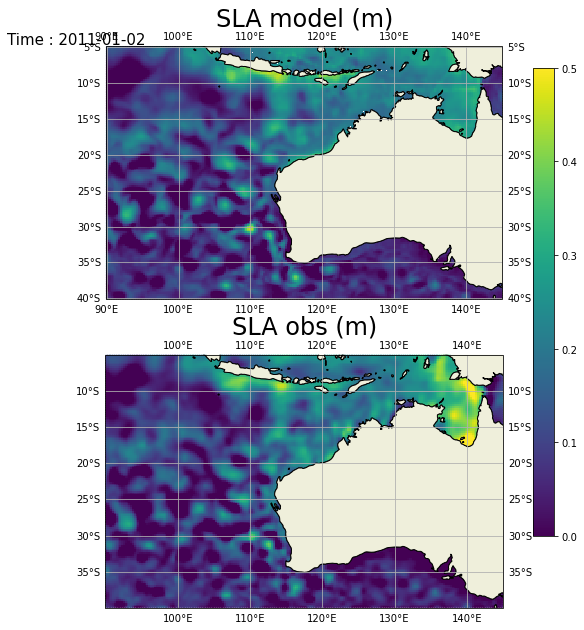

In [8]:
# define the caracteristics of the plot
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(211,projection=ccrs.PlateCarree())
ax2 = f.add_subplot(212,projection=ccrs.PlateCarree())
for ax in [ax1,ax2]:
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')    

# add the date to the plot
date = np.datetime_as_string(file1['time'].data[0],unit='D')
plt.suptitle('Time : ' +date ,fontsize = 15, x = 0.1, y = 0.9,horizontalalignment='left')

# first plot
ax1.pcolor(lon_zos,lat_zos,sla_model[0],vmin=0,vmax=0.5,shading='nearest')

# second plot
im2 = ax2.pcolor(file2['lon'].data,file2['lat'].data,file2['sla'].data[0,0],vmin=0,vmax=0.5,shading='nearest')

# legend
ax1.set_title('SLA model (m)',fontsize=24)
ax2.set_title('SLA obs (m)',fontsize=24)
f.subplots_adjust(right = 0.9, bottom = 0.1, hspace= 0.22,wspace=0.01)
cbar_ax = f.add_axes([0.83, 0.2, 0.03, 0.65])
f.colorbar(im2,cax=cbar_ax)
plt.savefig('DIVE/FIGURES/Part2/SLA_model_vs_obs.png')

The patterns look similar in the observations and in the model, the latter being more energetic at mesoscales.
Now let's plot an average annual cycle of SLA on the region.

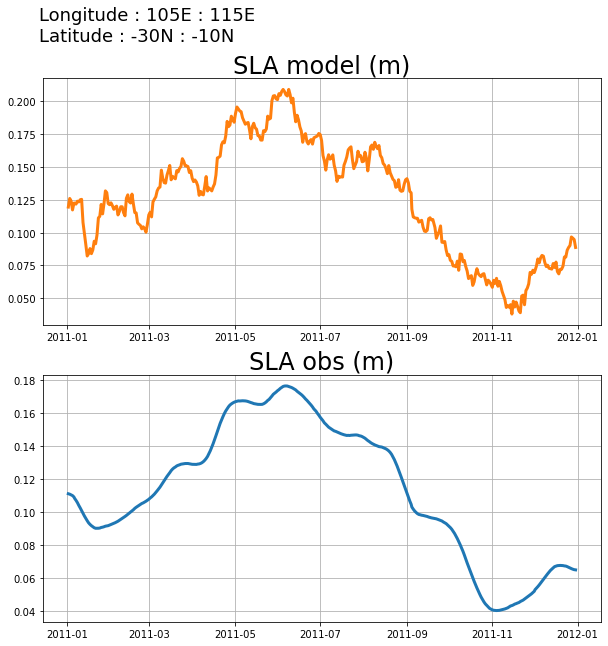

In [9]:
# calculate the average SLA in the select region
sla_model_sub = sla_model.sel(latitude=slice(-30,-10), longitude=slice(105,115))
sla_model_mean = sla_model_sub.mean('longitude').mean('latitude')

sla_obs_sub = file2['sla'].sel(lat=slice(-30,-10), lon=slice(105,115))
sla_obs_mean = sla_obs_sub.mean('lon').mean('lat')

# define the caracteristics of the plot  
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(211)
ax2 = f.add_subplot(212)

# add the coordinates to the plot
lon = '105E : 115E'
lat = '-30N : -10N'
f.suptitle('Longitude : ' +lon +'\nLatitude : ' + lat,fontsize=18,horizontalalignment='left',x=0.12)

# first plot
ax1.set_title("SLA model (m)",fontsize=24)
ax1.grid()

ax1.plot(file1['time'][0:364],sla_model_mean[0:364],c='tab:orange',linewidth=3)

# second plot
ax2.set_title("SLA obs (m)",fontsize=24)
ax2.grid()

ax2.plot(file1['time'][0:364],sla_obs_mean[1:365,0],c='tab:blue',linewidth=3)
plt.savefig('DIVE/FIGURES/Part2/average_SLA_model_vs_obs.png')

Now we sample the data at some tide gauges as in Ridgway and Godfrey (2015) : points E I J K L M N O P Q R from Ridgway and Godfrey 2015, from North to South:  
- Manokwari (E)
- Weipa (I) 
- Darwin (J) 
- Cape Londonderry (K)
- Broome (L) 
- Port Hedland (M)  
- Dampier (N) 
- North West Cape (O)
- Shark Bay (P) 
- Geraldton (Q) 
- Cape Leeuwin (R)          
- Kangaroo Island (S).

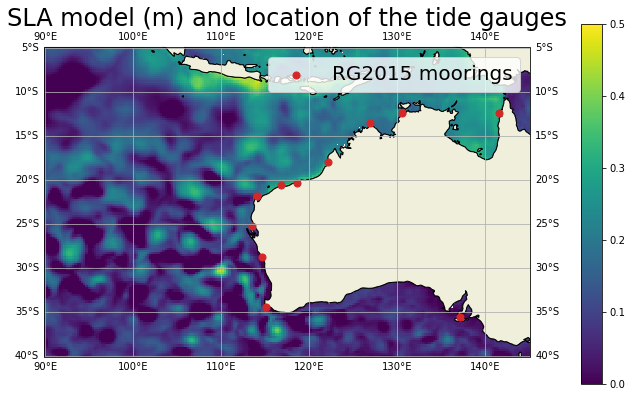

In [10]:
# define the coordinates of the tide gauges
xpts = [141.6,130.6,126.9,122.1,118.6,116.8,114.1,113.5,114.6,115.1,137.2]
ypts = [-12.4,-12.4,-13.5,-17.9,-20.3,-20.6,-21.8,-25.2,-28.8,-34.4,-35.6]

# define the caracteristics of the plot  
f = plt.figure(figsize=(10, 10))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
ax.set_title('SLA model (m) and location of the tide gauges',fontsize=24)

# plot data
im = ax.pcolor(lon_zos,lat_zos,sla_model[0],vmin=0,vmax=0.5,shading='nearest')
rg15 = ax.scatter(xpts,ypts,c='tab:red',zorder=2,s=50, label = 'RG2015 moorings')

# legend
cbar_ax = f.add_axes([0.87, 0.25, 0.03, 0.5])
f.subplots_adjust(right = 0.8, hspace= 0.,wspace=0.3)
f.colorbar(im,cax=cbar_ax)
ax.legend(handles = [rg15],fontsize=20) 
plt.savefig('DIVE/FIGURES/Part2/RG2015_moorings.png')

Some tide gauges time series available from the Global Sea Level Observing System GLOSS :     
- Darwin (J)
- Broome (L)
- Port Hedland (M)
- Carnavon (shark bay P )
- Fremantle
- Thevenard
- Esperance  

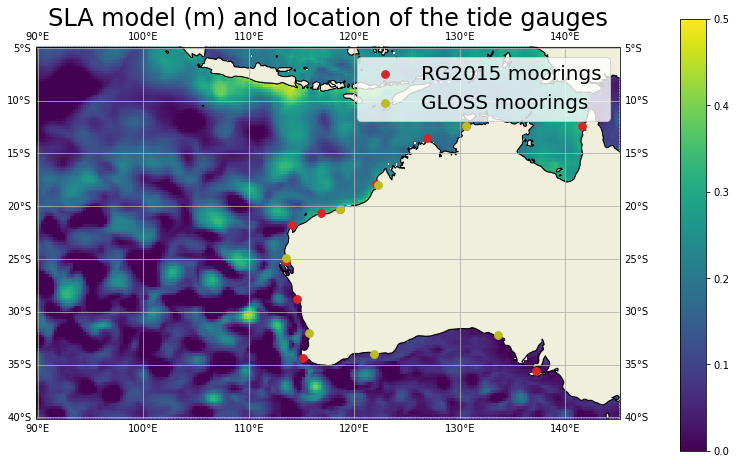

In [11]:
# define the coordinates of the tide gauges
xpts_gloss = [130.6,122.2,118.6,113.55, 115.7,133.6,121.9]
ypts_gloss = [-12.4,-18.,-20.3,-24.9,-32.,-32.2,-33.95]

# define the caracteristics of the plot  
f = plt.figure(figsize=(12, 12))
ax = plt.axes(projection=ccrs.PlateCarree())

ax.coastlines()
ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')
ax.set_title('SLA model (m) and location of the tide gauges',fontsize=24)

# plot data
im = ax.pcolor(lon_zos,lat_zos,sla_model[0],vmin=0,vmax=0.5,shading='nearest')
rg15 = ax.scatter(xpts,ypts,c='tab:red',zorder=2,s=60, label = 'RG2015 moorings')
gloss = ax.scatter(xpts_gloss,ypts_gloss,c='tab:olive',zorder=2,s=60, label = 'GLOSS moorings')

# legend
cbar_ax = f.add_axes([0.87, 0.25, 0.03, 0.5])
f.subplots_adjust(right = 0.8, hspace= 0.,wspace=0.3)
f.colorbar(im,cax=cbar_ax)
ax.legend(handles = [rg15,gloss],fontsize=20)  
plt.savefig('DIVE/FIGURES/Part2/RG2015+gloss_moorings.png')

Here we sample the model and satellite SLA onto tide gauges x and y points.

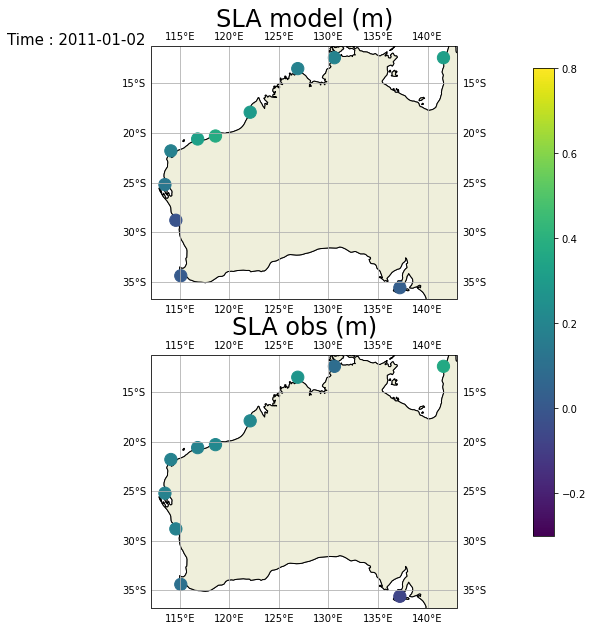

In [12]:
# sample the data 
sample_sla_model = sla_model.sel(longitude=xpts,latitude=ypts,method="nearest")
sample_sla_model = [sample_sla_model[0,i,i] for i in range(11)]
sample_sla_obs = file2['sla'].sel(lon=xpts,lat=ypts,method="nearest")
sample_sla_obs = [sample_sla_obs[0,0,i,i] for i in range(11)]


# define the plot caracteristics
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(211,projection=ccrs.PlateCarree())
ax2 = f.add_subplot(212,projection=ccrs.PlateCarree())

for ax in [ax1,ax2]:
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# add the date to the plot
date = np.datetime_as_string(file1['time'].data[0],unit='D')
plt.suptitle('Time : ' +date ,fontsize = 15, x = 0.1, y = 0.9,horizontalalignment='left')

# plot data
im1 =ax1.scatter(xpts,ypts,c=sample_sla_model,zorder=2,s=150,vmin=-0.3,vmax=0.8)
im2 = ax2.scatter(xpts,ypts,c=sample_sla_obs,zorder=2,s=150,vmin=-0.3,vmax=0.8)

# legend 
ax1.set_title('SLA model (m)',fontsize=24)
ax2.set_title('SLA obs (m)',fontsize=24)
f.subplots_adjust(right = 0.9, bottom = 0.1, hspace= 0.22,wspace=0.01)
cbar_ax = f.add_axes([0.83, 0.2, 0.03, 0.65])
f.colorbar(im2,cax=cbar_ax)
plt.savefig('DIVE/FIGURES/Part2/RG2015_moorings_sla_model_vs_obs.png')

<div class="alert alert-block alert-success">
<b>Question 1 :</b> What can you observe on these graphs?
</div>

Let's move to GLOSS moorings and let's check that we correctly sample the annual cycle and amplitude and phase changes along the coast.

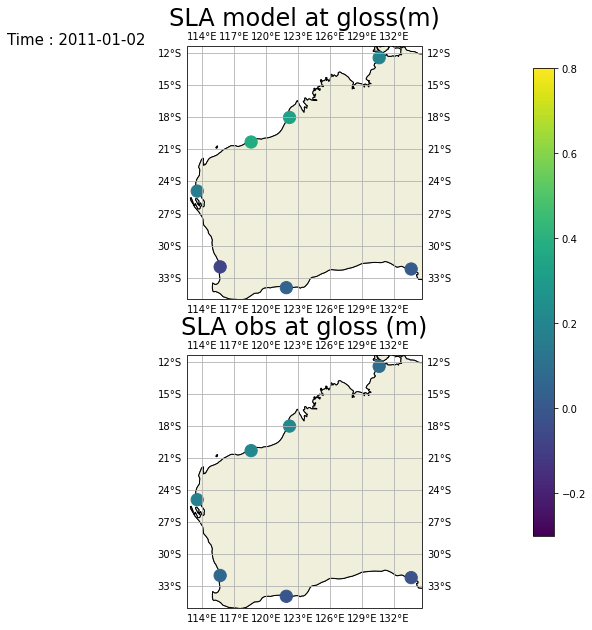

In [13]:

sample_sla_model_gloss = sla_model.sel(longitude=xpts_gloss,latitude=ypts_gloss,method="nearest")
sample_sla_model_gloss = [sample_sla_model_gloss[0,i,i] for i in range(7)]
sample_sla_obs_gloss = file2['sla'].sel(lon=xpts_gloss,lat=ypts_gloss,method="nearest")
sample_sla_obs_gloss = [sample_sla_obs_gloss[0,0,i,i] for i in range(7)]



# define the plot caracteristics
f = plt.figure(figsize=(10,10))
ax1 = f.add_subplot(211,projection=ccrs.PlateCarree())
ax2 = f.add_subplot(212,projection=ccrs.PlateCarree())

for ax in [ax1,ax2]:
    ax.coastlines()
    ax.gridlines(draw_labels=True, dms=True, x_inline=False, y_inline=False)
    ax.add_feature(cfeature.LAND, zorder=1, edgecolor='k')

# add the date to the plot
date = np.datetime_as_string(file1['time'].data[0],unit='D')
plt.suptitle('Time : ' +date ,fontsize = 15, x = 0.1, y = 0.9,horizontalalignment='left')

# plot data
im1 = ax1.scatter(xpts_gloss,ypts_gloss,c=sample_sla_model_gloss,zorder=2,s=150,vmin=-0.3,vmax=0.8)
im2 = ax2.scatter(xpts_gloss,ypts_gloss,c=sample_sla_obs_gloss,zorder=2,s=150,vmin=-0.3,vmax=0.8)


# legend 
ax1.set_title('SLA model at gloss(m)',fontsize=24)
ax2.set_title('SLA obs at gloss (m)',fontsize=24)
f.subplots_adjust(right = 0.9, bottom = 0.1, hspace= 0.22,wspace=0.01)
cbar_ax = f.add_axes([0.83, 0.2, 0.03, 0.65])
f.colorbar(im2,cax=cbar_ax)
plt.savefig('DIVE/FIGURES/Part2/gloss_moorings_sla_model_vs_obs.png')

Now we will load the tide gauges observations and compare the model, the SLA and the tide gauges measurements.

In [14]:
# define the paths of the netcdf files to use
path_file4 = 'DIVE/LEEUWIN/DATA/OBS/DARWIN_20100101_20160531.nc'
path_file5 = 'DIVE/LEEUWIN/DATA/OBS/BROOME_20100101_20160531.nc'
path_file6 = 'DIVE/LEEUWIN/DATA/OBS/PORT_HEDLAND_20100101_20120603.nc'
path_file7 = 'DIVE/LEEUWIN/DATA/OBS/CARNARVON_20100101_20121231.nc'
path_file8 = 'DIVE/LEEUWIN/DATA/OBS/FREMANTLE_20100101_20160531.nc'
path_file9 = 'DIVE/LEEUWIN/DATA/OBS/THEVENARD_20100101_20160531.nc'
path_file10 = 'DIVE/LEEUWIN/DATA/OBS/ESPERANCE_20100101_20160531.nc'

# open the netcdf file
file4 = xr.open_dataset(path_file4)
file5 = xr.open_dataset(path_file5)
file6 = xr.open_dataset(path_file6)
file7 = xr.open_dataset(path_file7)
file8 = xr.open_dataset(path_file8)
file9 = xr.open_dataset(path_file9)
file10 = xr.open_dataset(path_file10)

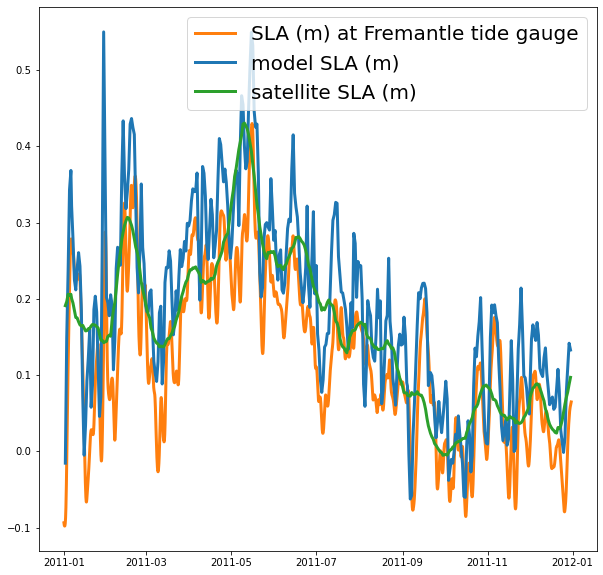

In [15]:
# sample the data
sample_sla_model = sla_model.sel(longitude=xpts,latitude=ypts,method="nearest")
sample_sla_obs = file2['sla'].sel(lon=xpts,lat=ypts,method="nearest")

# define the first and last dates to plot
date1 = np.datetime64('2011-01-01')
date2 = np.datetime64('2011-12-31')


f = plt.figure(figsize=(10, 10))
ax = plt.axes()

sla_fermantle = file8['ssh_from_tidegauge']-file8['ssh_from_tidegauge'].mean('time')-file8['ssh_from_tide']-file8['ssh_from_IB']

# plot data
p1, = ax.plot(file8['time'].sel(time=slice(date1,date2)),
        sla_fermantle[:,0,0].sel(time=slice(date1,date2)),
        c='tab:orange',linewidth=3, label = 'SLA (m) at Fremantle tide gauge')

p2, = ax.plot(file1['time'].sel(time=slice(date1,date2)),
        sample_sla_model[:,8,8].sel(time=slice(date1,date2)),
        c='tab:blue',linewidth=3, label = 'model SLA (m)')
p3, = ax.plot(file1['time'].sel(time=slice(date1,date2)),
        sample_sla_obs[1:365,0,8,8],
        c='tab:green',linewidth=3, label = 'satellite SLA (m)')

# legend 
ax.legend(handles = [p1,p2,p3],fontsize=20)
plt.savefig('DIVE/FIGURES/Part2/SLA_tg_model_obs.png')

<div class="alert alert-block alert-success">
<b>Question 2 :</b>  Look at several tide gauges. What can explain the differences between the tide gauges and the altimetry/model?
</div>